# CmdStanPy Tutorial


### Workflow Outline

Given a dataset and a model specification written as a Stan program, the CmdStanPy workflow is:

#### Assemble input data as either:
  + a Python `dict` object consisting of key-value pairs where the key corresponds
 to Stan data variables and the value is of the correct type and shape.
  + an existing data file on disk in either JSON or Rdump format.
  + CmdStanPy provides methods for converting former to latter.




#### Compile Stan program - function `compile_model`
  + takes as input a Stan program and produces the corresponding c++ executable.
  + both Stan program and c++ executable exist as on-disk files

#### Assemble input data as either:
  + a Python `dict` object consisting of key-value pairs where the key corresponds
 to Stan data variables and the value is of the correct type and shape.
  + an existing data file on disk in either JSON or Rdump format.

#### Run sampler - function `sample`
  + invokes Stan's NUTS-HMC sampler to condition model on input data, produces output csv files
  + runs any number of chains - should run at least 2 (default)
  + lightweight object `RunSet` keeps track of sampler arguments, per-chain outcome, output files
  + returns `PosteriorSample` object which contains information about sample

#### Analyze resulting `PosteriorSample`
  + `PosteriorSample` contains names of csv output files, names of csv column headers
  + attribute `sample` assembles in-memory sample from csv files
  + methods `summary` and `diagnose` invoke CmdStan tools `bin/stansummary` and `bin/diagnose` respectively


### Installation

* Download this repo from GitHub

* run script `make_cmdstan.sh` - (need equivalent for Windows) - this installs and builds cmdstan in subdirectory `releases`




### Example 1:  example model `bernoulli.stan`, data `bernoulli.data.json`

Import relevant classes and methods


In [1]:
import os
import os.path
from cmdstanpy.lib import Model, PosteriorSample
from cmdstanpy.cmds import compile_model, sample

The CmdStanPy directory `test/data` contains models

In [2]:
datafiles_path = os.path.expanduser(
    os.path.join("~", "github", "stan-dev", "cmdstanpy", "test", "data"))
stan = os.path.join(datafiles_path, "bernoulli.stan")

Call `compile_model` with path to Stan program, returns `Model` object `bernoulli_model`

In [3]:
bernoulli_model = compile_model(stan)
print(bernoulli_model)

Model(name=bernoulli,  stan_file="/Users/mitzi/github/stan-dev/cmdstanpy/test/data/bernoulli.stan", exe_file="/Users/mitzi/github/stan-dev/cmdstanpy/test/data/bernoulli")


Input data is either a Python `Dict` with entries corresponding to input data values, or it can be a file in JSON or Rdump format.  If a `Dict` is specified, CmdStanPy writes it to a temp file in JSON format.

In [4]:
bern_data = { "N" : 10, "y" : [0,1,0,0,0,0,0,0,0,1] }

Call `sample` to run NUTS-HMC sampler, returns `PosteriorSample` object `a_sample`

In [5]:
a_sample = sample(bernoulli_model, chains=4, cores=2, data=bern_data)

input data tempfile: /var/folders/sc/0f0wdc_11_xgjs2v52g20fvr0000gn/T/tmpnn3si19v/tmpvfm5ytyn.json
start chain 1.  start chain 2.  

finish chain 2.  
start chain 3.  
finish chain 1.  
start chain 4.  
finish chain 3.  
finish chain 4.  


In [6]:
print(a_sample)

PosteriorSample(chains=4,  draws=1000, columns=8)


### `PosteriorSample` object functions and attributes

#### PosteriorSample.summary()

The `summary` function returns output of CmdStan bin/stansummary as pandas.DataFrame:

In [7]:
a_sample.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-7.288520,0.017688,0.738774,-8.849610,-7.008580,-6.750170,1744.39,8684.48,1.00096
theta,0.249456,0.003236,0.120517,0.073465,0.235161,0.464975,1386.90,6904.73,1.00046


#### PosteriorSample.diagnose()

The `diagnose` function prints diagnostics to console:

In [8]:
a_sample.diagnose()

No problems detected.


#### PosteriorSample.sample

The `sample` property is a 3-D numpy ndarray which contains all draws across all chains.  The ndarray is stored column major format so that values for each parameter are stored contiguously in memory, likewise all draws from a chain are contiguous.  Thus the dimensions of the ndarray are arranged as follows:  (draws, chains, columns):

In [9]:
a_sample.sample
a_sample.sample.shape

(1000, 4, 8)

#### PosteriorSample.extract()

The `extract` function flattens the `sample` 3-dimensional ndarray (draws X chains X columns) to a  pandas.DataFrame, (i.e., a 2-dimensional ndarray), one draw per row.  

((4000, 8),
 Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
        'divergent__', 'energy__', 'theta'],
       dtype='object'),
 <matplotlib.axes._subplots.AxesSubplot at 0x11f2ed438>)

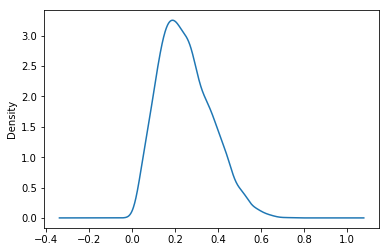

In [11]:
samp = a_sample.extract()
samp.shape, samp.columns, samp.theta.plot.density()

In [12]:
thetas = a_sample.extract(params=['theta'])
thetas.shape


(4000, 1)